<a href="https://colab.research.google.com/github/AhamadAli30/Defect-Detection-using-Deep-Learning/blob/main/Metal_Detection_Vggnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

In [3]:
train_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/train'
test_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/test'
valid_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/valid'

In [4]:
# prompt: find the total number of images in the directory
import os
def count_images(directory):
  total_images = 0
  for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    for file in os.listdir(subdir_path):
      if file.endswith(".bmp"):
        total_images += 1
    print(f"in {subdir_path} = {total_images}")
  print()
  return total_images

train_images = count_images(train_dir)
test_images = count_images(test_dir)
valid_images = count_images(valid_dir)

total_images = train_images + test_images + valid_images
print(f"Number of training images: {train_images}")
print(f"Number of testing images: {test_images}")
print(f"Number of validation images: {valid_images}")

print(f"Total number of images: {total_images}")


in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Scratches = 226
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Patches = 452
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Rolled = 678
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Pitted = 904
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Inclusion = 1130
in /content/drive/MyDrive/NEU Metal Surface Defects Data/train/Crazing = 1356

in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Patches = 12
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Inclusion = 24
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Crazing = 36
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Scratches = 48
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Rolled = 60
in /content/drive/MyDrive/NEU Metal Surface Defects Data/test/Pitted = 72

in /content/drive/MyDrive/NEU Metal Surface Defects Data/valid/Pitted = 62
in /c

In [ ]:
len(test_dir)

58

In [ ]:
len(valid_dir)

59

Pre-Processing

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1356 images belonging to 6 classes.
Found 372 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [6]:
# Check batch size
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32, 6)


In [7]:
# Check class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


In [8]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

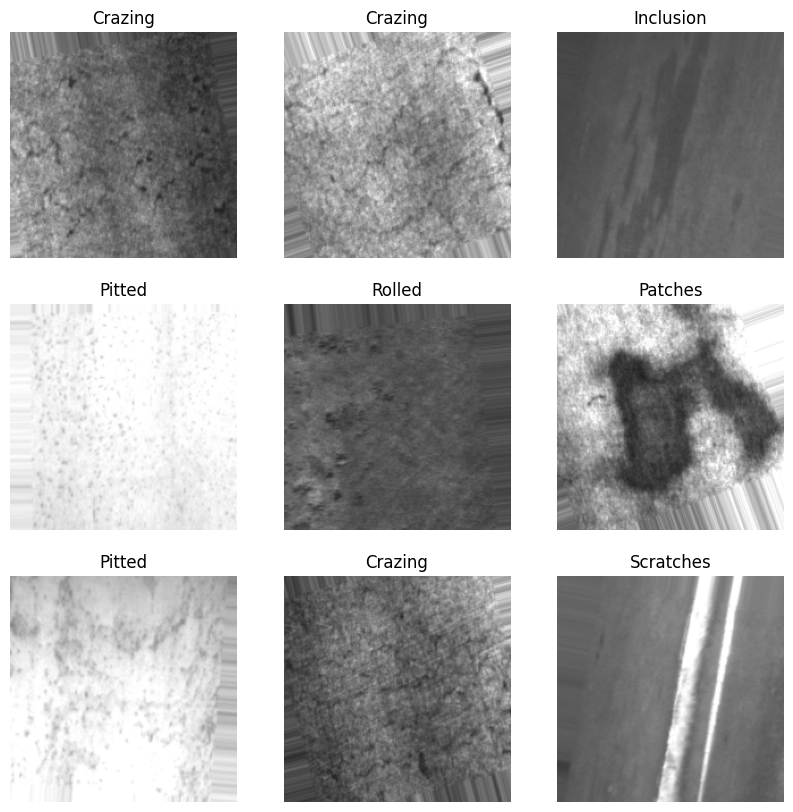

In [ ]:
sample_images(train_generator, nrows=3, ncols=3)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [10]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense

def vgg_block(x, num_filters, num_conv_layers):
    for _ in range(num_conv_layers):
        x = Conv2D(num_filters, kernel_size=3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2, strides=2)(x)
    return x

def build_vgg(input_shape=(200, 200, 3), num_classes=6, num_blocks=[2, 2, 2, 2]):
    input_layer = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', activation='relu')(input_layer)
    x = BatchNormalization()(x)

    # VGG Blocks
    for block_num, num_filters in enumerate([64, 128, 256, 512]):
        x = vgg_block(x, num_filters, num_blocks[block_num])

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)

    # Output Layer
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=x, name='vgg_like')

    return model

# Create a VGG-like model with default parameters
vgg_model = build_vgg()

# Display the model summary
vgg_model.summary()


Model: "vgg_like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      9472      
                                                                 
 batch_normalization (Batch  (None, 100, 100, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      369

In [11]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [12]:
history = vgg_model.fit(train_generator,
                    epochs=10,
                    batch_size=16,
                    validation_data=valid_generator)

Epoch 1/10
43/43 [==============================] - 641s 15s/step - loss: 67.4471 - accuracy: 0.3525 - val_loss: 15.8632 - val_accuracy: 0.2366
Epoch 2/10
43/43 [==============================] - 23s 533ms/step - loss: 3.0411 - accuracy: 0.3931 - val_loss: 7.8931 - val_accuracy: 0.2930
Epoch 3/10
43/43 [==============================] - 22s 516ms/step - loss: 3.7240 - accuracy: 0.3997 - val_loss: 53.9324 - val_accuracy: 0.1667
Epoch 4/10
43/43 [==============================] - 20s 472ms/step - loss: 1.8802 - accuracy: 0.4012 - val_loss: 12.7009 - val_accuracy: 0.1640
Epoch 5/10
43/43 [==============================] - 22s 504ms/step - loss: 1.4588 - accuracy: 0.5170 - val_loss: 8.5390 - val_accuracy: 0.2446
Epoch 6/10
43/43 [==============================] - 20s 469ms/step - loss: 1.2363 - accuracy: 0.5981 - val_loss: 9.7928 - val_accuracy: 0.1667
Epoch 7/10
43/43 [==============================] - 21s 488ms/step - loss: 1.1255 - accuracy: 0.6475 - val_loss: 9.7546 - val_accuracy: 0.1

In [18]:
print("Accuracy:", history.history['accuracy'][-1])
print("Loss:", history.history['loss'][-1])

Accuracy: 0.76474928855896
Loss: 0.7708051800727844


In [13]:

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('categorical_crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

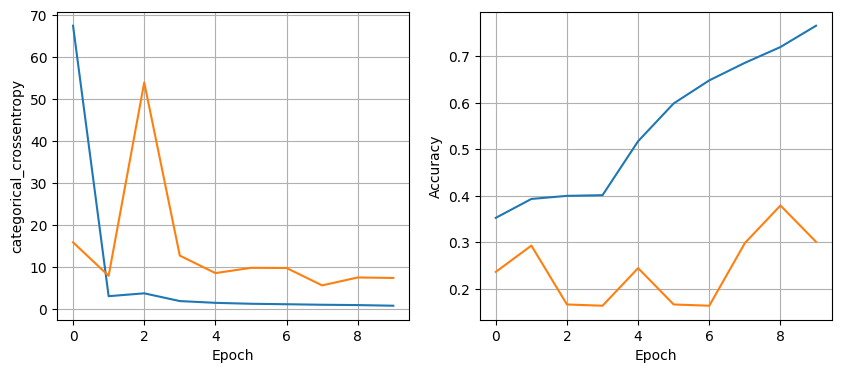

In [14]:
plot_history(history)

In [15]:
def plot_hist(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

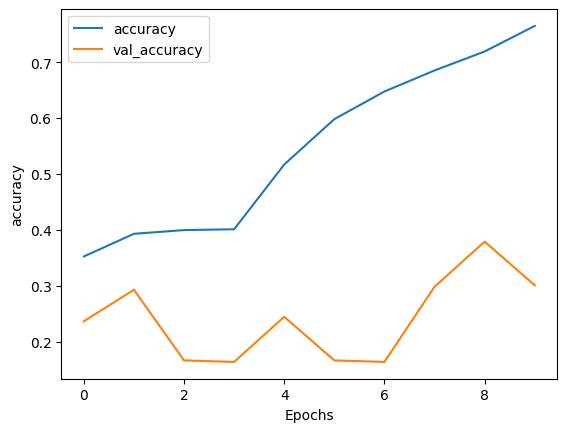

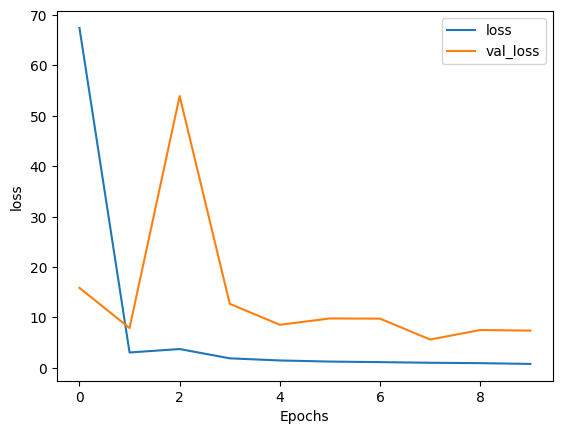

In [16]:
plot_hist(history, 'accuracy')
plot_hist(history, 'loss')

1/1 [==============================] - 0s 24ms/step


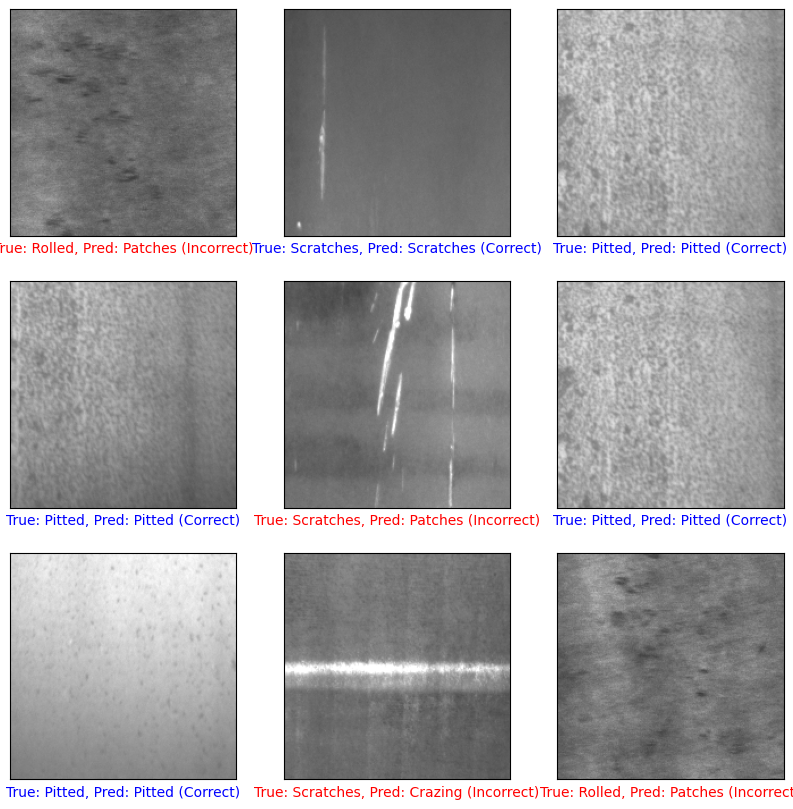

In [19]:
images, labels = next(test_generator)

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = vgg_model.predict(images)

class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = images[i]

    if image.shape[-1] == 1:
        image = np.squeeze(image)

    plt.imshow(image)

    predicted_label = np.argmax(predictions[i])

    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"

    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"

    plt.xlabel(label_text,color=color)

3/3 [==============================] - 4s 2s/step


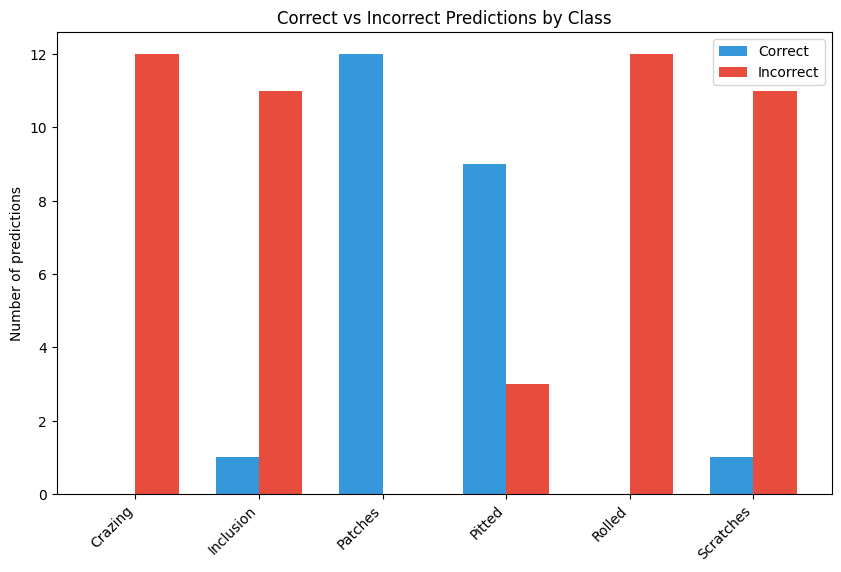

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels for the test set
true_labels = test_generator.classes

# Get the predicted labels from the model
predicted_labels = np.argmax(vgg_model.predict(test_generator), axis=1)

# Initialize a dictionary to store the number of correct and incorrect predictions for each class
class_predictions = {}

# Loop through each class
for class_name in class_names:
  # Get the indices of the test samples belonging to the current class
  class_indices = np.where(true_labels == class_names.index(class_name))[0]

  # Get the predicted labels for the current class
  class_predicted_labels = predicted_labels[class_indices]

  # Calculate the number of correct and incorrect predictions for the current class
  correct_predictions = np.sum(class_predicted_labels == class_names.index(class_name))
  incorrect_predictions = len(class_indices) - correct_predictions

  # Store the results in the dictionary
  class_predictions[class_name] = {
      "correct": correct_predictions,
      "incorrect": incorrect_predictions
  }

# Create a bar chart showing the number of correct and incorrect predictions for each class
plt.figure(figsize=(10, 6))

x_labels = class_names
y_values = [
    [class_predictions[class_name]["correct"] for class_name in class_names],
    [class_predictions[class_name]["incorrect"] for class_name in class_names]
]

bar_width = 0.35
x_positions = np.arange(len(x_labels))

plt.bar(x_positions - bar_width/2, y_values[0], bar_width, label="Correct", color="#3498db")
plt.bar(x_positions + bar_width/2, y_values[1], bar_width, label="Incorrect", color="#e74c3c")

plt.xticks(x_positions, x_labels, rotation=45, ha="right")
plt.ylabel("Number of predictions")
plt.title("Correct vs Incorrect Predictions by Class")
plt.legend()
plt.show()


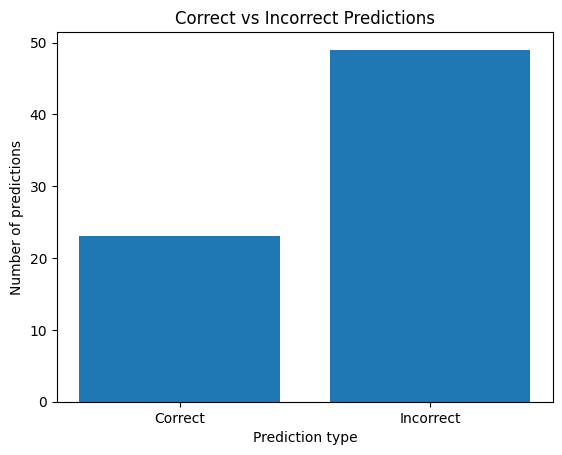

In [23]:

import matplotlib.pyplot as plt
labels = ['Correct', 'Incorrect']
correct_predictions = sum([class_predictions[class_name]["correct"] for class_name in class_names])
incorrect_predictions = sum([class_predictions[class_name]["incorrect"] for class_name in class_names])
values = [correct_predictions, incorrect_predictions]

plt.bar(labels, values)
plt.xlabel('Prediction type')
plt.ylabel('Number of predictions')
plt.title('Correct vs Incorrect Predictions')
plt.show()


In [24]:
import os
import pickle
model_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/'
model_name = 'vgg_model.h5'
model_path = os.path.join(model_dir, model_name)
vgg_model.save(model_path)

history_path = os.path.join(model_dir, 'history.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "vgg_like"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      9472      
                                                                 
 batch_normalization (Batch  (None, 100, 100, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 100, 100, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      369

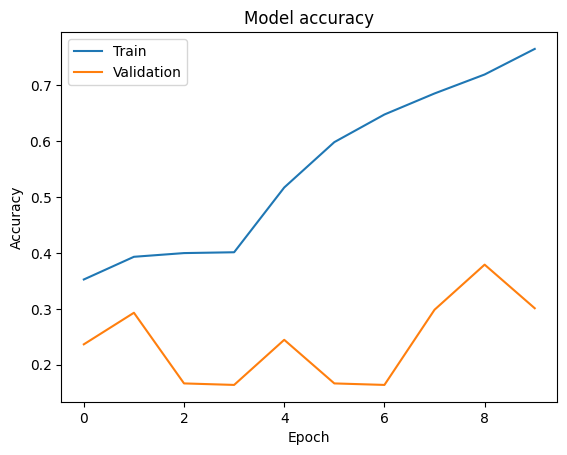

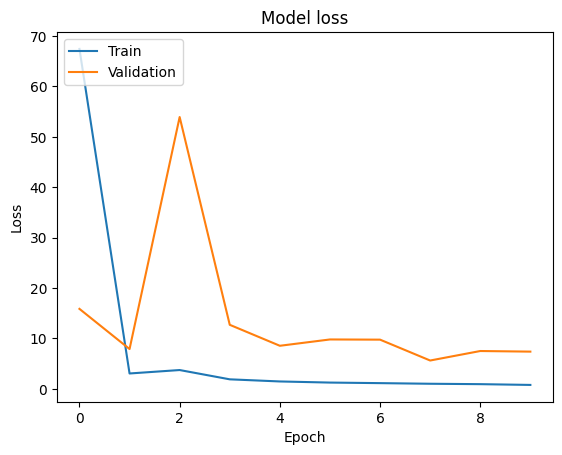

In [25]:
import matplotlib.pyplot as plt
# Load the saved model
model_path = '/content/drive/MyDrive/NEU Metal Surface Defects Data/vgg_model.h5'
vgg_model_1 = tf.keras.models.load_model(model_path)

# Load the saved history
history_path = '/content/drive/MyDrive/NEU Metal Surface Defects Data/history.pkl'
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# Print the model summary
vgg_model_1.summary()

# Evaluate the model on the test set
test_loss, test_acc = vgg_model_1.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
